<a href="https://colab.research.google.com/github/ash-myth/AQI_Analysis/blob/main/AQI_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Air Quality (PM2.5): A Complete Regression & Classification Project

This notebook presents a complete, high-quality workflow for predicting PM2.5 levels. It combines advanced regression techniques with the classification and user-input components from your original project.

**Key Features:**
* **Advanced Preprocessing:** Uses time-based interpolation to handle missing data (`0.0` values) without losing data continuity.
* **Robust Feature Engineering:** Creates lag and rolling features for both PM2.5 and key weather variables.
* **Correct Time-Series Validation:** Uses a strict `shuffle=False` train/test split and `TimeSeriesSplit` for cross-validation to prevent data leakage and simulate real-world forecasting.
* **Dual-Task Modeling:**
    1.  **Regression:** Predicts the *exact* PM2.5 value.
    2.  **Classification:** Predicts the *AQI Category* (e.g., 'Good', 'Moderate').
* **Model Comparison:** Systematically compares multiple regression models (Ridge, Lasso, Random Forest, XGBoost) on both regression and classification metrics.
* **Hyperparameter Tuning:** Uses `GridSearchCV` to optimize the best-performing model.
* **Final User Prediction:** Includes a cell at the end to load the saved model and make predictions on new user-supplied data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

In [ ]:
file_path = 'Real_Combine.csv'
df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df.set_index('date', inplace=True)

print(f"Original count of 0.0 values in PM_25: {(df['PM_25'] == 0).sum()}")
df['PM_25'] = df['PM_25'].replace(0.0, np.nan)
print(f"Total NaN values in PM_25 (original + zeros): {df['PM_25'].isnull().sum()}")

df.interpolate(method='time', inplace=True)
if df.isnull().values.any():
    print("Filling remaining NaNs with backfill.")
    df.fillna(method='bfill', inplace=True)

print(f"Total NaNs remaining: {df.isnull().sum().sum()}")
print("\n--- Data Head After Preprocessing ---")
print(df.head())

Original count of 0.0 values in PM_25: 30
Total NaN values in PM_25 (original + zeros): 33
Total NaNs remaining: 0

--- Data Head After Preprocessing ---
               T    TM   Tm     SLP   H   VV    V    VM       PM_25
date                                                               
2019-01-01  12.8  22.6  4.0  1020.0  75  1.3  2.0   9.4  284.795833
2019-01-02  13.8  23.0  6.5  1020.7  79  1.1  0.9   3.5  219.720833
2019-01-03  13.5  23.4  6.7  1021.3  83  0.6  7.2  22.2  182.187500
2019-01-04  12.2  20.5  7.1  1020.3  88  0.6  5.0  25.9  115.287500
2019-01-05  13.2  21.0  5.4  1018.2  83  1.3  6.5  22.2   63.833333


In [ ]:
def get_aqi_category(pm25):
    if pm25 <= 50:
        return 'Good'
    elif pm25 <= 100:
        return 'Satisfactory'
    elif pm25 <= 200:
        return 'Moderate'
    elif pm25 <= 300:
        return 'Poor'
    elif pm25 <= 400:
        return 'Very Poor'
    else:
        return 'Severe'
df['AQI_Category'] = df['PM_25'].apply(get_aqi_category)

print("--- AQI Category Distribution ---")
print(df['AQI_Category'].value_counts(normalize=True) * 100)


--- AQI Category Distribution ---
AQI_Category
Poor            25.276309
Very Poor       19.702066
Moderate        18.020183
Satisfactory    15.040846
Good            13.791446
Severe           8.169149
Name: proportion, dtype: float64


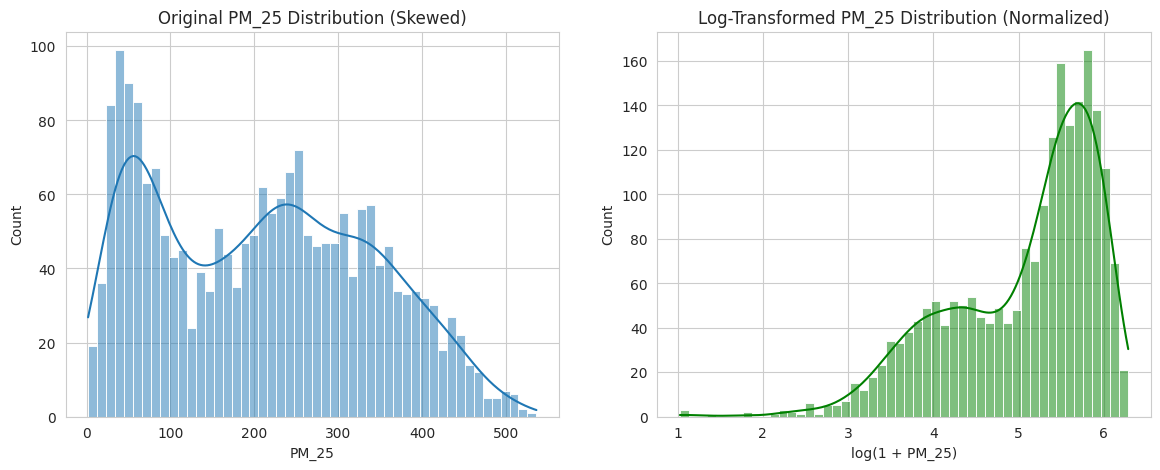

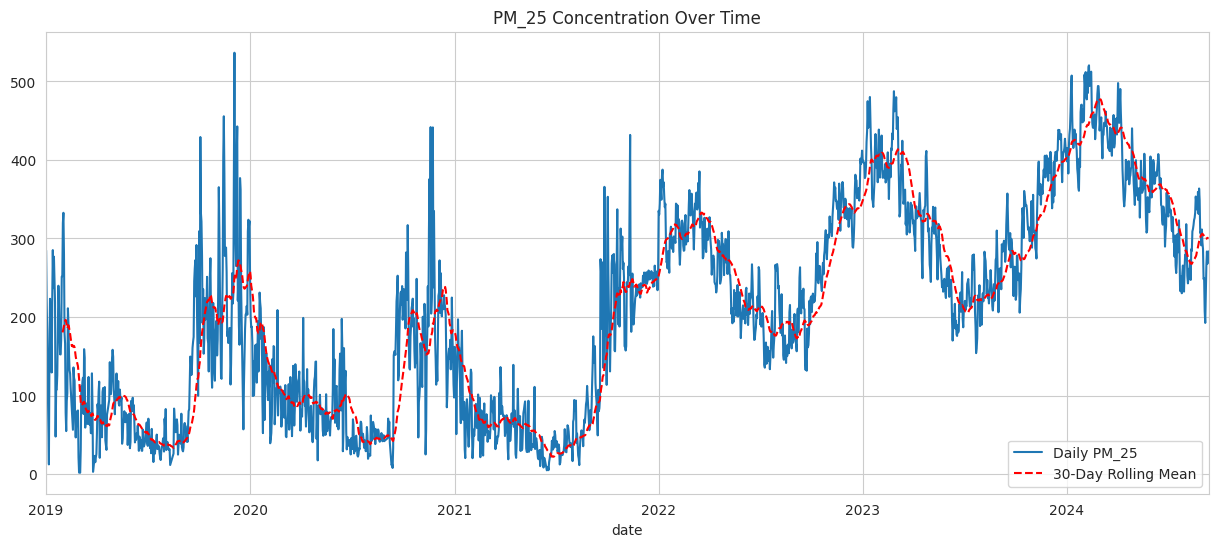

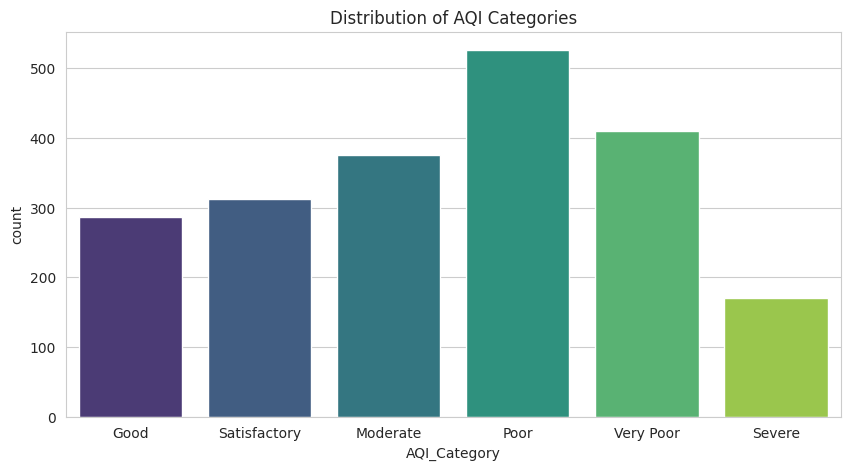

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['PM_25'], kde=True, bins=50)
plt.title('Original PM_25 Distribution (Skewed)')
df['PM_25_log'] = np.log1p(df['PM_25'])

plt.subplot(1, 2, 2)
sns.histplot(df['PM_25_log'], kde=True, bins=50, color='green')
plt.title('Log-Transformed PM_25 Distribution (Normalized)')
plt.xlabel('log(1 + PM_25)')
plt.show()
plt.figure(figsize=(15, 6))
df['PM_25'].plot(label='Daily PM_25')
df['PM_25'].rolling(window=30).mean().plot(label='30-Day Rolling Mean', color='red', linestyle='--')
plt.title('PM_25 Concentration Over Time')
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))
category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']
sns.countplot(x='AQI_Category', data=df, order=category_order, palette='viridis')
plt.title('Distribution of AQI Categories')
plt.show()

In [ ]:
def create_features(df_in):
    df = df_in.copy()
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['PM_25_log_lag_1'] = df['PM_25_log'].shift(1)
    df['PM_25_log_roll_avg_7'] = df['PM_25_log_lag_1'].rolling(window=7).mean()
    weather_features = ['T', 'H', 'V', 'VM']
    for col in weather_features:
        df[f'{col}_lag_1'] = df[col].shift(1)

    return df

df_feat = create_features(df)
df_clean = df_feat.dropna()
print(f"Original shape: {df.shape}, Shape after FE: {df_clean.shape}")


Original shape: (2081, 11), Shape after FE: (2074, 19)


In [ ]:
drop_cols = ['PM_25', 'PM_25_log', 'AQI_Category']
X = df_clean.drop(drop_cols, axis=1)
feature_names = X.columns.tolist()
y_reg_log = df_clean['PM_25_log']
y_reg_orig = df_clean['PM_25']
y_class = df_clean['AQI_Category']

print(f"Feature set shape: {X.shape}")
print("\n--- Features being used for modeling ---")
print(feature_names)

Feature set shape: (2074, 16)

--- Features being used for modeling ---
['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'month', 'day_of_year', 'PM_25_log_lag_1', 'PM_25_log_roll_avg_7', 'T_lag_1', 'H_lag_1', 'V_lag_1', 'VM_lag_1']


X_train shape: (1659, 16)
X_test shape: (415, 16)


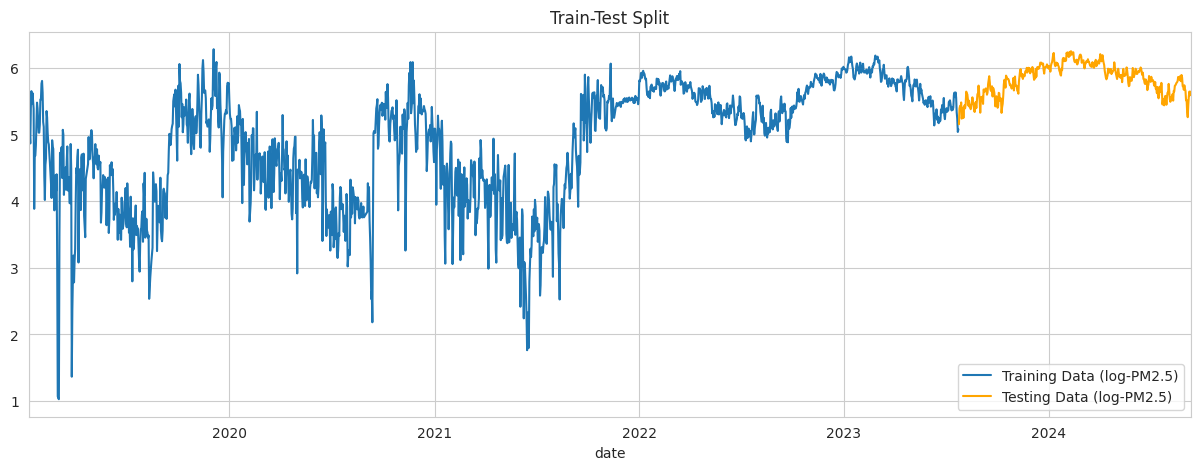

In [ ]:
test_set_size = 0.2
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_reg_log, test_size=test_set_size, shuffle=False)
y_test_orig = y_reg_orig.loc[y_test_log.index]
y_test_class = y_class.loc[y_test_log.index]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
plt.figure(figsize=(15, 5))
y_train_log.plot(label='Training Data (log-PM2.5)')
y_test_log.plot(label='Testing Data (log-PM2.5)', color='orange')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

--- Training Ridge ---
  [Regression] R²: 0.7399, MAE: 32.4012, RMSE: 39.7526
  [Classification] Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         0
Satisfactory       0.00      0.00      0.00         0
    Moderate       0.17      0.25      0.20         4
        Poor       0.71      0.88      0.79       119
   Very Poor       0.63      0.76      0.69       171
      Severe       0.98      0.45      0.62       121

    accuracy                           0.70       415
   macro avg       0.42      0.39      0.38       415
weighted avg       0.75      0.70      0.69       415



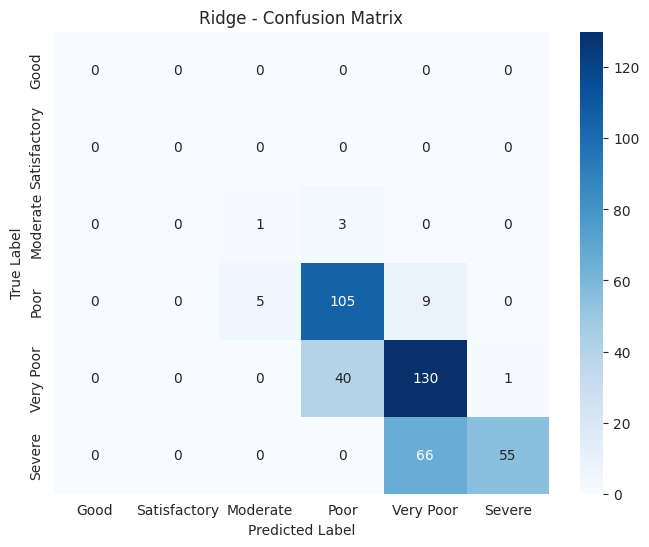

--- Training Lasso ---
  [Regression] R²: -8.0585, MAE: 221.2664, RMSE: 234.5937
  [Classification] Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         0
Satisfactory       0.00      0.00      0.00         0
    Moderate       0.01      1.00      0.02         4
        Poor       0.00      0.00      0.00       119
   Very Poor       0.00      0.00      0.00       171
      Severe       0.00      0.00      0.00       121

    accuracy                           0.01       415
   macro avg       0.00      0.17      0.00       415
weighted avg       0.00      0.01      0.00       415



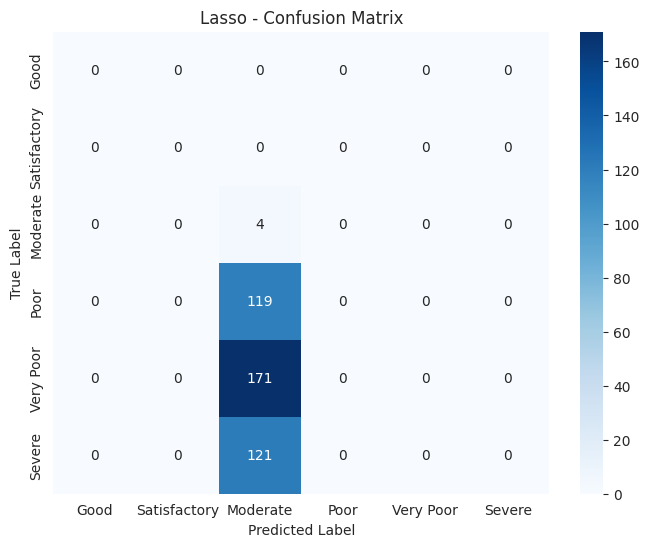

--- Training RandomForest ---
  [Regression] R²: 0.8565, MAE: 23.0702, RMSE: 29.5247
  [Classification] Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         0
Satisfactory       0.00      0.00      0.00         0
    Moderate       0.17      0.25      0.20         4
        Poor       0.82      0.87      0.85       119
   Very Poor       0.80      0.83      0.82       171
      Severe       0.91      0.79      0.85       121

    accuracy                           0.83       415
   macro avg       0.45      0.46      0.45       415
weighted avg       0.83      0.83      0.83       415



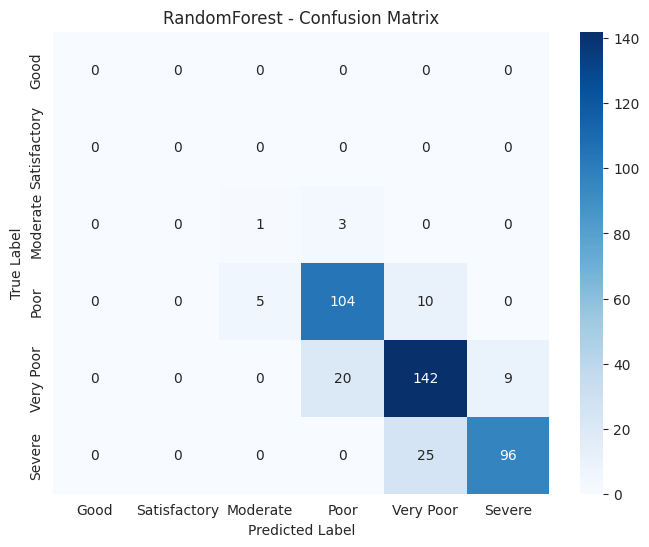

--- Training XGBoost ---
  [Regression] R²: 0.4888, MAE: 42.8375, RMSE: 55.7316
  [Classification] Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         0
Satisfactory       0.00      0.00      0.00         0
    Moderate       0.06      0.25      0.10         4
        Poor       0.60      0.82      0.69       119
   Very Poor       0.59      0.60      0.60       171
      Severe       0.84      0.45      0.58       121

    accuracy                           0.61       415
   macro avg       0.35      0.35      0.33       415
weighted avg       0.66      0.61      0.62       415



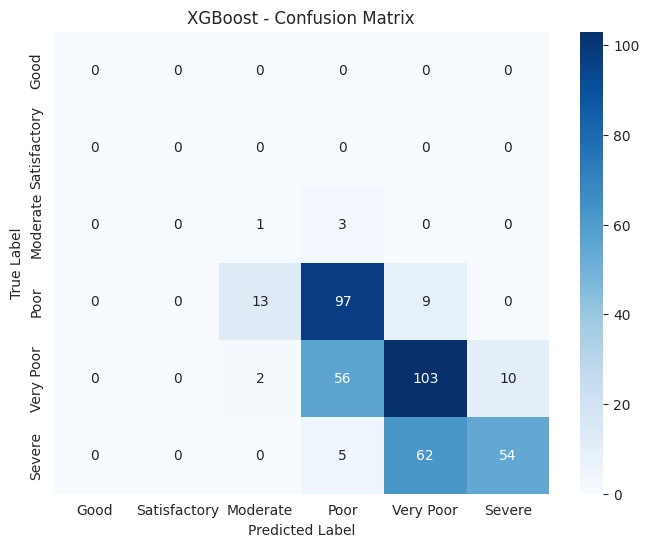


--- Model Comparison Summary (Regression Metrics) ---


,name,R2,MAE,RMSE
2,RandomForest,0.856518,23.070165,29.524685
0,Ridge,0.739890,32.401222,39.752613
3,XGBoost,0.488755,42.837469,55.731642
1,Lasso,-8.058540,221.266392,234.593715


In [ ]:
models = {
    'Ridge': {'model': Ridge(), 'scaled': True},
    'Lasso': {'model': Lasso(), 'scaled': True},
    'RandomForest': {'model': RandomForestRegressor(random_state=42, n_jobs=-1), 'scaled': False},
    'XGBoost': {'model': XGBRegressor(random_state=42, n_jobs=-1), 'scaled': False}
}

results = []
category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

for name, m in models.items():
    print(f"--- Training {name} ---")
    X_tr = X_train_scaled if m['scaled'] else X_train
    X_te = X_test_scaled if m['scaled'] else X_test
    m['model'].fit(X_tr, y_train_log)

    y_pred_log = m['model'].predict(X_te)
    y_pred_orig = np.expm1(y_pred_log)

    r2 = r2_score(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

    print(f"  [Regression] R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    y_pred_class = [get_aqi_category(p) for p in y_pred_orig]

    print("  [Classification] Report:")
    print(classification_report(y_test_class, y_pred_class, labels=category_order))

    results.append({'name': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'model_obj': m['model']})
    cm = confusion_matrix(y_test_class, y_pred_class, labels=category_order)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=category_order, yticklabels=category_order)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
print("\n--- Model Comparison Summary (Regression Metrics) ---")
display(results_df[['name', 'R2', 'MAE', 'RMSE']])

In [ ]:
print("--- Starting Hyperparameter Tuning for RandomForest ---")
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_leaf': [2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=2
)
grid_search.fit(X_train, y_train_log)

print("\n--- Tuning Complete ---")
print(f"Best Parameters Found: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

--- Starting Hyperparameter Tuning for RandomForest ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.2s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.3s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.5s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   0.4s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   0.9s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   1.1s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   1.4s
[CV] END .max_depth=10, min_samples_leaf=4, n_estimators=100; total time= 

--- Evaluating the Tuned Random Forest Model ---
  [Regression] R²: 0.8700, MAE: 22.1418, RMSE: 28.1070
  [Classification] Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00         0
Satisfactory       0.00      0.00      0.00         0
    Moderate       0.25      0.25      0.25         4
        Poor       0.82      0.89      0.85       119
   Very Poor       0.80      0.84      0.82       171
      Severe       0.93      0.78      0.85       121

    accuracy                           0.83       415
   macro avg       0.47      0.46      0.46       415
weighted avg       0.84      0.83      0.83       415



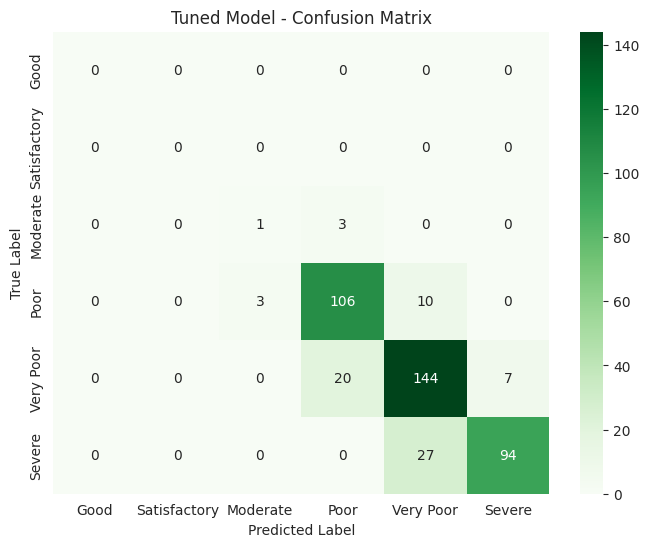

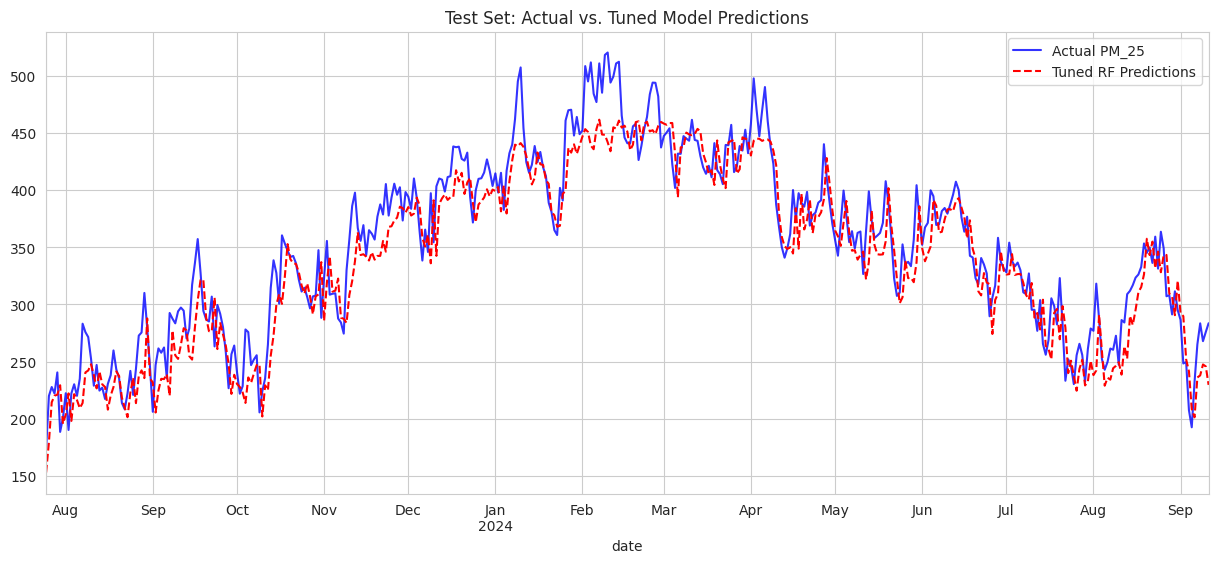

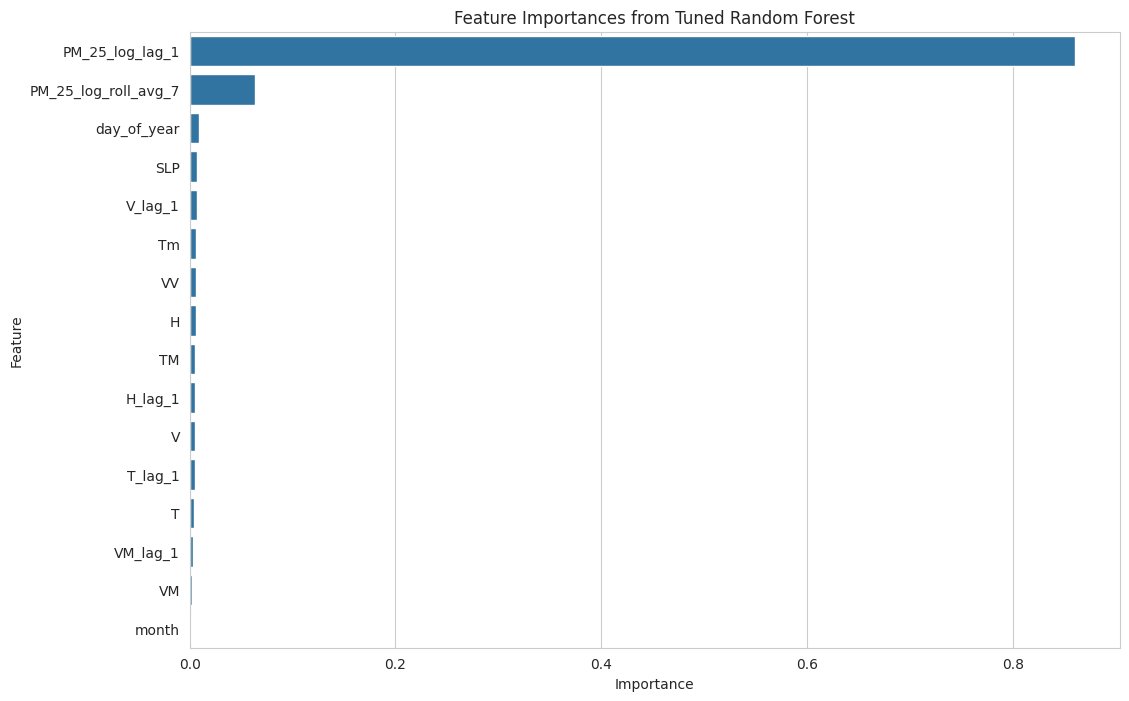

In [ ]:
print("--- Evaluating the Tuned Random Forest Model ---")
y_pred_log_tuned = best_rf_model.predict(X_test)
y_pred_orig_tuned = np.expm1(y_pred_log_tuned)

r2 = r2_score(y_test_orig, y_pred_orig_tuned)
mae = mean_absolute_error(y_test_orig, y_pred_orig_tuned)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig_tuned))
print(f"  [Regression] R²: {r2:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")
y_pred_class_tuned = [get_aqi_category(p) for p in y_pred_orig_tuned]
print("  [Classification] Report:")
print(classification_report(y_test_class, y_pred_class_tuned, labels=category_order))

cm = confusion_matrix(y_test_class, y_pred_class_tuned, labels=category_order)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=category_order, yticklabels=category_order)
plt.title('Tuned Model - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
plt.figure(figsize=(15, 6))
y_pred_orig_tuned_series = pd.Series(y_pred_orig_tuned, index=y_test_orig.index)

y_test_orig.plot(label='Actual PM_25', color='blue', alpha=0.8)
y_pred_orig_tuned_series.plot(label='Tuned RF Predictions', color='red', linestyle='--')
plt.title('Test Set: Actual vs. Tuned Model Predictions')
plt.legend()
plt.show()
importances = best_rf_model.feature_importances_
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances from Tuned Random Forest')
plt.show()


In [ ]:
joblib.dump(best_rf_model, 'aqi_rf_model_final.joblib')

joblib.dump(scaler, 'aqi_scaler_final.joblib')

joblib.dump(feature_names, 'aqi_feature_names_final.joblib')

print("Final model ('aqi_rf_model_final.joblib'), ")
print("scaler ('aqi_scaler_final.joblib'), ")
print("and feature list ('aqi_feature_names_final.joblib') have been saved.")

Final model ('aqi_rf_model_final.joblib'), 
scaler ('aqi_scaler_final.joblib'), 
and feature list ('aqi_feature_names_final.joblib') have been saved.


In [ ]:
if loaded_model:
    user_data_features = {}

    print("\n--- Please Enter Basic Weather & PM2.5 Data ---")

    def get_float_input(prompt, default=None):
        while True:
            try:
                val = input(f"{prompt} [{default if default is not None else ''}]: ")
                return float(val) if val.strip() != '' else (default if default is not None else 0.0)
            except ValueError:
                print(f"  -> Invalid input. Please enter a number.\n")

    while True:
        try:
            date_str = input("Enter Today's Date (DD-MM-YYYY): ")
            today_date = pd.to_datetime(date_str, format='%d-%m-%Y')
            user_data_features['month'] = today_date.month
            user_data_features['day_of_year'] = today_date.dayofyear
            break
        except ValueError:
            print("  -> Invalid date format. Use DD-MM-YYYY.\n")
    user_data_features['T'] = get_float_input("Today's Avg Temp (°C)", 25)
    user_data_features['H'] = get_float_input("Today's Avg Humidity (%)", 60)
    user_data_features['V'] = get_float_input("Today's Avg Wind Speed (km/h)", 5)
    user_data_features['VM'] = get_float_input("Today's Max Wind Speed (km/h)", 10)
    user_data_features['T_lag_1'] = user_data_features['T']
    user_data_features['H_lag_1'] = user_data_features['H']
    user_data_features['V_lag_1'] = user_data_features['V']
    user_data_features['VM_lag_1'] = user_data_features['VM']
    print("\n--- Enter PM2.5 Data for Past 3 Days ---")
    pm_values = []
    for i in range(1, 4):
        pm_values.append(get_float_input(f"PM2.5 value from {i} day(s) ago", 200))

    user_data_features['PM_25_log_lag_1'] = np.log1p(pm_values[0])
    user_data_features['PM_25_log_roll_avg_7'] = np.mean([np.log1p(p) for p in pm_values])
    print("\n--- Calculating Prediction... ---")
    input_df = pd.DataFrame([user_data_features], columns=loaded_features)

    predicted_aqi_log = loaded_model.predict(input_df)
    predicted_aqi = np.expm1(predicted_aqi_log)
    predicted_category = get_aqi_category(predicted_aqi[0])

    print("\n--- Prediction Results ---")
    print(f"Predicted PM2.5 Value: {predicted_aqi[0]:.2f}")
    print(f"Predicted AQI Category: {predicted_category}")



--- Please Enter Basic Weather & PM2.5 Data ---
Enter Today's Date (DD-MM-YYYY): 04-11-2025
Today's Avg Temp (°C) [25]: 29
Today's Avg Humidity (%) [60]: 81
Today's Avg Wind Speed (km/h) [5]: 6
Today's Max Wind Speed (km/h) [10]: 9

--- Enter PM2.5 Data for Past 3 Days ---
PM2.5 value from 1 day(s) ago [200]: 139
PM2.5 value from 2 day(s) ago [200]: 213
PM2.5 value from 3 day(s) ago [200]: 180

--- Calculating Prediction... ---

--- Prediction Results ---
Predicted PM2.5 Value: 140.33
Predicted AQI Category: Moderate
